In [2]:
import numpy as np
import pandas as pd
import matplotlib as mpl
# mpl.use('Cairo')  # for saving SVGs that Affinity Designer can parse
import matplotlib.pyplot as plt
import seaborn as sns

import candas as can
import gumbi as gmb
from candas.lims import Librarian, library
from candas.learn import ParameterSet
import pathlib as pl

code_pth = pl.Path.cwd()  # for running in Jupyter
# code_pth = pl.Path(__file__)  # for running in terminal
fig_pth = code_pth.parent
data_pth = fig_pth / 'data'
graph_pth = fig_pth / 'graphics'
graph_pth.mkdir(exist_ok=True)

gen_pth = fig_pth / 'generated'
gen_pth.mkdir(exist_ok=True)

plt.style.use(str(can.style.breve))

%config InlineBackend.figure_format = 'retina'

In [3]:
import dill

In [4]:
ps = ParameterSet.load(data_pth / "ADVI_ParameterSets_220528.pkl")


def make_pair(row):
    return "-".join(sorted([row.FPrimer, row.RPrimer]))


data = (
    ps.wide.query('Metric == "mean"')
    .astype({"BP": float})
    .assign(PrimerPair=lambda df: df.apply(make_pair, axis=1))
    .groupby(["Target", "PrimerPair", "Reporter"])
    .mean()
    .reset_index()
)

ds = gmb.DataSet(
    data=data,
    outputs=["F0_lg", "r", "K", "m"],
    log_vars=["BP", "K", "m", "r"],
    logit_vars=["GC"],
)

/tmp/ipykernel_1359/44787224.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data = (ps.wide


# LMC

In [ ]:
gp = gmb.GP(ds).fit(
    continuous_dims=["BP", "GC"],
    categorical_dims=["PrimerPair", "Reporter"],
)

In [6]:
selected = (
    data.groupby(["PrimerPair", "Reporter"])
    .size()
    .reset_index()
    .rename(columns={0: "Observations"})
    .sort_values("Observations", ascending=False)
    .reset_index(drop=True)
).iloc[[0, 1, 4, 5, 6, 8, 38, 39, 42]]

limits = gp.parray(GC=[0.2, 0.8], BP=[10, 600])
XY = gp.prepare_grid(limits=limits)
BP, GC = XY["BP"], XY["GC"]

all_r = []

for _, row in selected.iterrows():
    r = gp.predict_grid(
        output="r",
        with_noise=False,
        categorical_levels={"Reporter": row.Reporter, "PrimerPair": row.PrimerPair},
    )

    all_r.append(r)

/tmp/ipykernel_1359/1767631487.py:37: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  ax.scatter(gc, bp, c='0.5', cmap='flare_r', norm=rnorm, s=10)
/tmp/ipykernel_1359/1767631487.py:37: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  ax.scatter(gc, bp, c='0.5', cmap='flare_r', norm=rnorm, s=10)
/tmp/ipykernel_1359/1767631487.py:37: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  ax.scatter(gc, bp, c='0.5', cmap='flare_r', norm=rnorm, s=10)
/tmp/ipykernel_1359/1767631487.py:37: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  ax.scatter(gc, bp, c='0.5', cmap='flare_r', norm=rnorm, s=10)
/tmp/ipykernel_1359/1767631487.py:37: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  ax.scatter(gc, bp, c='0.5', cmap='flare_r', norm=rnorm, s=10)


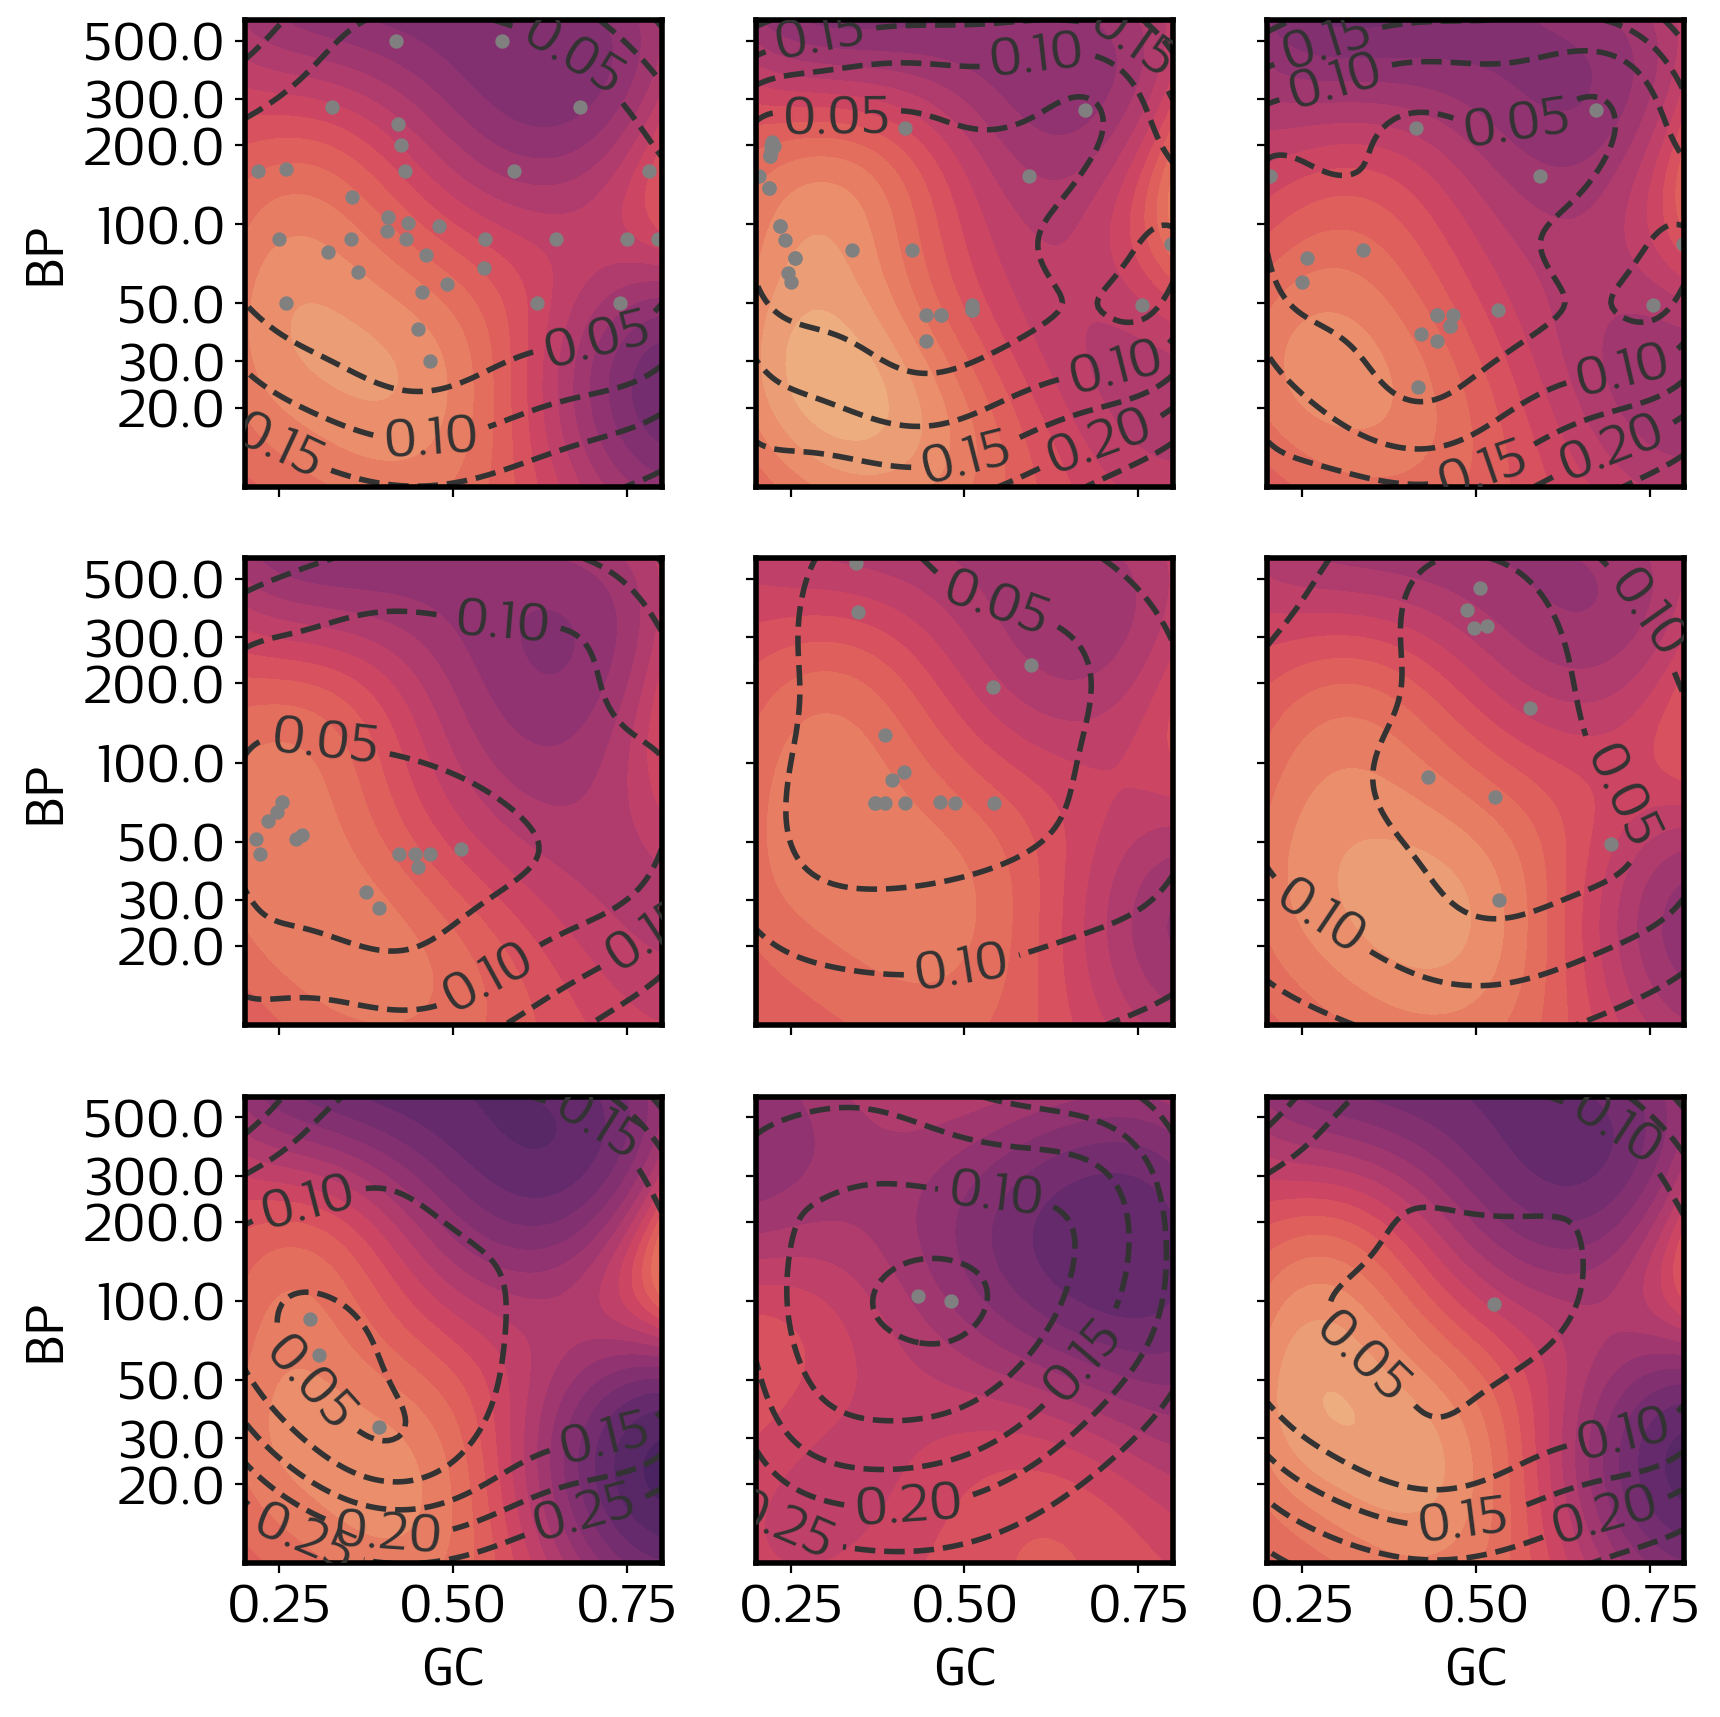

In [7]:
rnorm = mpl.colors.Normalize()
rnorm(np.stack([r.μ for r in all_r]))

fig, axs = plt.subplots(3, 3, figsize=(9, 9), sharex=True, sharey=True)

for i, (r, ax, row) in enumerate(zip(all_r, axs.flat, selected.itertuples())):
    plt.sca(ax)
    pp = gmb.ParrayPlotter(
        x=GC,
        y=BP,
        z=r,
        #    x_scale='standardized',
        y_scale="standardized",
    )

    step = 0.05
    levels = (
        np.arange(np.floor(rnorm.vmin / step), np.ceil(rnorm.vmax / step) + 1) * step
    )
    cs = pp(plt.contourf, levels=levels, cmap="flare_r", norm=rnorm)
    # pp.colorbar(cs)

    yticks = gp.parray(BP=[20, 30, 50, 100, 200, 300, 500])
    ax.set_yticks(yticks["BP"].z.values())
    ax.set_yticklabels(yticks.values())

    if i % 3 != 0:
        ax.set_ylabel("")
    if i // 3 != 2:
        ax.set_xlabel("")

    gc = ds.wide.query("Reporter == @row.Reporter and PrimerPair == @row.PrimerPair").GC
    bp = ds.wide.z.query(
        "Reporter == @row.Reporter and PrimerPair == @row.PrimerPair"
    ).BP

    ax.scatter(gc, bp, c="0.5", cmap="flare_r", norm=rnorm, s=10)

    ax.set_xlim(limits["GC"].values())

    cs = ax.contour(
        GC.values(),
        BP.z.values(),
        r.σ,
        levels=[0.05, 0.10, 0.15, 0.20, 0.25],
        colors="0.2",
        linestyles="--",
    )
    ax.clabel(cs)

plt.tight_layout()

In [8]:
predictions_dict = {f"r{i}": r for i, r in enumerate(all_r)}
# predictions_dict['all_r'] = all_r
predictions_dict["BP"] = BP
predictions_dict["GC"] = GC

In [9]:
## Dill needs to "warm up" for some reason??

# for r in all_r:
#     dump = dill.dumps(r)
#     loaded = dill.loads(dump)

for value in predictions_dict.values():
    dump = dill.dumps(value)
    loaded = dill.loads(dump)

In [10]:
with open(gen_pth / "Model_LMC_predictions.pkl", "wb") as f:
    dill.dump(predictions_dict, f)

with open(gen_pth / "Model_LMC_predictions.pkl", "rb") as f:
    loaded = dill.load(f)

loaded

{'r0': r['μ', 'σ2']: [[(0.78775155, 0.037887  ) (0.79027644, 0.03741755)
   (0.79281081, 0.03695032) ... (0.47583956, 0.04332875)
   (0.47334581, 0.04371751) (0.47121636, 0.04410876)]
  [(0.79146437, 0.0367603 ) (0.79409795, 0.03627166)
   (0.79673682, 0.03578598) ... (0.46684293, 0.04212848)
   (0.46430251, 0.04253531) (0.46213486, 0.04294565)]
  [(0.7952755 , 0.0356102 ) (0.79802053, 0.03510302)
   (0.80076623, 0.03459961) ... (0.45804176, 0.04087912)
   (0.45545782, 0.04130366) (0.45325467, 0.04173281)]
  ...
  [(0.55540184, 0.01600022) (0.55099325, 0.01531248)
   (0.54674045, 0.01463015) ... (0.53164163, 0.0200051 )
   (0.53917464, 0.02093437) (0.546825  , 0.0218759 )]
  [(0.54951462, 0.01700291) (0.54496447, 0.01628593)
   (0.54057021, 0.01557383) ... (0.53236214, 0.02123842)
   (0.5396655 , 0.02217814) (0.54707992, 0.02312803)]
  [(0.54399571, 0.01802028) (0.53931435, 0.01727569)
   (0.53478873, 0.01653541) ... (0.53358947, 0.02249482)
   (0.54066667, 0.02344222) (0.54784839, 0.0